<a href="https://colab.research.google.com/github/kyle-gao/DNN_from_scratch/blob/master/DNN_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2020 Yi Lin(Kyle) Gao

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 .


In [ ]:
!pip install mnist

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import mnist
import copy

In [ ]:
train_X = mnist.train_images()/255.0
train_Y = mnist.train_labels()

test_X = mnist.test_images()/255.0
test_Y = mnist.test_labels()

(60000, 784)
1


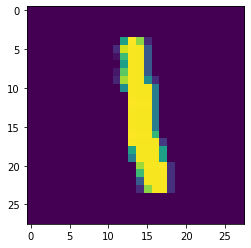

In [ ]:
id = 6
train_X=np.reshape(train_X,(-1,28*28))
test_X=np.reshape(test_X,(-1,28*28))
firstX=train_X[id,:]
firstX=np.reshape(firstX,(28,28))
plt.imshow(firstX)
print(np.shape(train_X))
print(train_Y[id])

Sigmoid and derivative

In [ ]:
def sigmoid(Z):
    #sigmoid function
    return  1/(1+np.exp(-Z))

def dsigmoid(Z):
    #sigmoid derivative
    return sigmoid(Z)*(1-sigmoid(Z))


RelU and derivative

In [ ]:
def relu(Z):
    #returns the element-wise relu of Z, fast implementation
    #Z -- an array of floats
    return Z * (Z > 0)

def drelu(Z):
    #relu derivative
    return 1. * (Z > 0)

Softmax and derivative

In [ ]:
def softmax(Z,eps=1e-10):
    """Numerically stable softmax
    Given (m,n) input, returns softmax over the last dimension"""
    shiftZ = Z - np.max(Z,axis=-1,keepdims=True)
    expZ=np.exp(shiftZ)
    total=np.sum(expZ,axis=-1,keepdims=True)+eps
    return expZ/total


def dsoftmax(Z):
    """Given a (m,n) matrix, returns a (m,n,n) jacobian matrix"""
    m,n=np.shape(Z)
    softZ=(softmax(Z))
    prodtensor=np.einsum("ij,ik->ijk",softZ,softZ)
    diagtensor=np.einsum('ij,jk->ijk', softZ, np.eye(n, n))
    return diagtensor-prodtensor

Derivative Testing

In [ ]:
def test_derivative(func,z,eps=1e-8):
    """2 sided derivative for single valued function or 'hadamard product type' function"""
    return (func(z+eps)-func(z-eps))/(2*eps)

def test_jac(func,Z,eps=1e-8):
    """Returns the jacobian (m,n,n) of a matrix function f:(m,n)->(m,n) 
        (jacobian over the second input axis 'n', 'm' is ignore)"""
    m,n=np.shape(Z)
    jacobian=np.zeros((m,n,n))
    for idx, ij in np.ndenumerate(Z):
        epsM=np.zeros((m,n))
        epsM[idx]=eps
        jacobian[idx[0],idx[1],:]=((func(Z+epsM)-func(Z-epsM))/(2*eps))[idx[0],:]
    return jacobian


"""#Test sigmoid
z=np.random.rand(5,3)
print(test_derivative(sigmoid,z)-dsigmoid(z))"""

"""#Test relu
z=np.random.rand(5,3)

print(test_derivative(sigmoid,z)-dsigmoid(z))"""

"""
#Test softmax
Z= np.random.rand(5,3)
print(np.isclose(test_jac(softmax,Z)-dsoftmax(Z),0,1e-8))"""


'\n#Test softmax\nZ= np.random.rand(5,3)\nprint(np.isclose(test_jac(softmax,Z)-dsoftmax(Z),0,1e-8))'

One hot encodding and loss function

In [ ]:
def one_hot(Y,n_class):
    #Y -- (m,) array of classes from (0 to n_class)
    #n_class -- an integer representing the number of classes
    """Returns the one_hot representation (m,n_class)"""
    m=np.shape(Y)[0]
    
    O_h=np.zeros((m,n_class))
    O_h[range(m),Y]=1
    
    return O_h

"""
#Test
ytest=train_Y[0:5]
print(one_hot(ytest,10))
print(train_Y[0:5])"""

'\n#Test\nytest=train_Y[0:5]\nprint(one_hot(ytest,10))\nprint(train_Y[0:5])'

In [ ]:
train_Y_oh=one_hot(train_Y,10)
test_Y_oh=one_hot(test_Y,10)

Loss function

In [ ]:
def categorical_crossentropy(Y,Yhat,eps=1e-8):
    #Y -- (m,dim_y) array of labels m=examples 
    #Yhat -- (m,dim_y) array of logits
    """Computes the categorical cross-entropy for one hot encoded labels"""
    m,dimy=np.shape(Y)
    Yhat=np.clip(Yhat,eps,1-eps) #for numerical stability if this is used, the output of the last layer must be normalized 

    #J=-(Y*np.log(Yhat)+(1-Y)*np.log(1-Yhat))
    J=-np.sum(Y*np.log(Yhat),axis=-1)
    #J=np.sum((Y-Yhat)*(Y-Yhat),axis=0)
    
    return np.sum(J,axis=0)/(m)

Preprocessing

In [ ]:
def get_rand_minibatch(X, Y, minibatch_size = 64):
    #inputs
    #X -- ( m,dim_x) array of labelled data 
    #Y -- (m,dim_y) array of labels
    #minibatch_size -- int, minibatch size
    #outputs
    #minibatches -- list of (X,Y), a list of tuple (miniX,miniY) of randomly shuffled minibatches
    
    m=X.shape[0]
    minibatches=[]
    
    rand_perm=np.random.permutation(m)
    shuffled_X=X[rand_perm,:]
    shuffled_Y=Y[rand_perm]
    num_batches=int(np.floor(m/minibatch_size))
    
    for b in range(num_batches):
        mini_X=shuffled_X[b*minibatch_size:(b+1)*minibatch_size,:]
        mini_Y=shuffled_Y[b*minibatch_size:(b+1)*minibatch_size]
        minibatches.append((mini_X,mini_Y))
    if m%minibatch_size !=0: #left over minibatch
        mini_X=shuffled_X[num_batches*minibatch_size:,:]
        mini_Y=shuffled_Y[num_batches*minibatch_size:]
        minibatches.append((mini_X,mini_Y))
    
    return minibatches

In [ ]:
def initialize_parameters(layers):
    #input
    #layers -- list of int:layer sizes, note: layer[0] is input layer, layer[L] is output layer
    
    #output
    #Ws,Bs -- lists of np arrays, the randomly initialized weights and zero initialized biases
    
    L=len(layers)
    Ws=[]
    Bs=[]
    
    for l in range(1,L):
        wl=np.random.randn(layers[l-1],layers[l])
        bl=np.zeros((layers[l],1))
        Ws.append(wl)
        Bs.append(bl)
    return Ws,Bs

In [ ]:
#Test
layers=[784,12,11,10]
Ws,bs=initialize_parameters(layers)

In [ ]:
def forward(A_prev,W,b,activation='relu'):
    #A_prev -- (m,dim_a_prev) 
    #W -- (dim_a,dim_a_prev)
    #b -- (dim_a,1)
    #activation -- a function (relu,sigmoid,softmax)
    Z=np.dot(A_prev,W)+b.T
    if activation=='relu':
        A_next=relu(Z)
    elif activation=='sigmoid':
        A_next=sigmoid(Z)
    elif activation=='linear':
        A_next=Z
    elif activation=='softmax':
        A_next=softmax(Z)
    else:
        A_next=None
        print('Activation not recognized')
    
    return A_next,Z

In [ ]:
#Test
A=np.random.rand(500,10)
W=np.random.randn(10,5)
b=np.random.randn(5,1)
Anext,__=forward(A,W,b)
print(np.shape(Anext))

(500, 5)


In [ ]:
def backward(dA,W,A_prev,Z,activation="relu"):
    #dA -- (m,dim_a) np.array
    #W -- dim (dim_a,dim_a_prev) np.array
    #A_prev -- (m,dim_a_prev) np.array
    #Z -- (m,dim_a) np.array
    m=A_prev.shape[0]
    
    if activation=='relu':
        dZ=dA*drelu(Z)
    elif activation=='sigmoid':
        dZ=dA*dsigmoid(Z)
    elif activation=='linear':
        dZ=dA
    elif activation=='softmax': #Can absorb the derivative of the softmax into the derivative of the loss function
        dZ=np.einsum("ijk,ij->ik",dsoftmax(Z),dA)
    else:
        A_next=None
        print('back Activation not recognized')
        
    dA_prev=np.dot(dZ,W.T)
    dW=np.dot(A_prev.T,dZ)/m
    dB=np.mean(dZ,axis=0)
    dB=np.reshape(dB,(len(dB),1))
    return dA_prev, dW, dB

In [ ]:
#Test
dA=np.ones((10,6))
W=np.ones((5,6))
A_prev=np.ones((10,5))
Z=np.ones((10,6))
da_prev,dW,dB=backward(dA,W,A_prev,Z,activation="relu")
print(dW)

[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]


In [ ]:
def forward_prop(Ws,Bs,X,middle_activations='relu',last_activation='softmax'):
    
    #inputs:
    #Ws -- list of weights
    #Bs -- list of biases
    #X -- input layer
    
    #output
    #As -- list of (n_a,m) arrays of activations
    
    As=[]
    Zs=[None]
    As.append(X)
    L=len(Ws)
    
    
    for i in range(L-1):
        Anext,Znext=forward(As[-1],Ws[i],Bs[i],middle_activations)
        As.append(Anext)
        Zs.append(Znext)
    Anext,Znext=forward(As[-1],Ws[L-1],Bs[L-1],last_activation)
    As.append(Anext)
    Zs.append(Znext)
   # Anext,Znext=forward(As[-1],Ws[L-1],Bs[L-1],'softmax')
   # As.append(Anext)
   # Zs.append(Znext)
    
    return As,Zs

In [ ]:
#Test
X_test=train_X[0:20,:]
Y_test=train_Y_oh[0:20]
As,Zs=forward_prop(Ws,bs,X_test)
np.shape(As[-1])

(20, 10)

In [ ]:
def back_prop(Ws,As,Y,Zs,middle_activations='relu',last_activation='softmax'):
    dAs=[]
    dWs=[]
    dBs=[]
   
    L=len(Ws)
    
    #The softmax derivative dL/dWij=dL/dai dai/dWij = (Y-A)*dZ which has the same form as the sigmoid derivative
    dA=As[-1]-Y 
    if last_activation=='softmax':
        last_activation='linear'
    dA, dW, dB=backward(dA,Ws[L-1],As[L-1],Zs[L],last_activation)
    #The linear backward layer takes into account both softmax and sigmoid final layers. 
    
    dWs.append(dW)
    dBs.append(dB)    
    for i in range(L-2,-1,-1):
        dA_prev, dW, dB=backward(dA,Ws[i],As[i],Zs[i+1],middle_activations)
        dWs.append(dW)
        dBs.append(dB)
        dA=dA_prev
    dWs.reverse()
    dBs.reverse()
    return dWs,dBs

In [ ]:
#Test
dWs,dBs=back_prop(Ws,As,train_Y_oh[0:20],Zs)
for dw in dWs:
    print(np.shape(dw))
for w in Ws:
    print(np.shape(w))

(784, 12)
(12, 11)
(11, 10)
(784, 12)
(12, 11)
(11, 10)


In [ ]:
def optmize(Ws,Bs,dWs,dBs,vdw=0,vdb=0,sdw=0,sdb=0,optimizer='adam',learn_rate=0.01,beta1=0.9,beta2=0.999,eps=10**-6,t=1):
    #W -- list of Weights
    #B -- list of Biases
    #dW -- list of d/dW
    #dB -- list of d/dB
    

    L=len(Ws)
    
    if optimizer=='adam' or optimizer=='momentum':
        vdw=[beta1*vdw[i]+(1-beta1)*dWs[i] for i in range (L)]
        vdb=[beta1*vdb[i]+(1-beta1)*dBs[i] for i in range (L)]
        #bias correction
        vdw=[vdwi/(1-np.power(beta1,t)) for vdwi in vdw] 
        vdb=[vdbi/(1-np.power(beta1,t)) for vdbi in vdb]
    if optimizer=='adam' or optimizer=='rmsprop':
        sdw=[beta2*sdw[i]+(1-beta2)*dWs[i]**2 for i in range(L)]
        sdb=[beta2*sdb[i]+(1-beta2)*dBs[i]**2 for i in range(L)]
        #bias correction
        sdw=[sdwi/(1-np.power(beta2,t))+eps for sdwi in sdw]
        sdb=[sdbi/(1-np.power(beta2,t))+eps for sdbi in sdb]
    if optimizer=='adam':
        Ws=[Ws[i]-learn_rate*vdw[i]/np.sqrt(sdw[i]) for i in range(L)]
        Bs=[Bs[i]-learn_rate*vdb[i]/np.sqrt(sdb[i]) for i in range(L)]
    if optimizer=='rmsprop':
        Ws=[Ws[i]-learn_rate*dWs[i]/np.sqrt(sdw[i]) for i in range(L)]
        Bs=[Bs[i]-learn_rate*dBs[i]/np.sqrt(sdb[i]) for i in range(L)]
    if optimizer=='momentum':
        Bs=[Bs[i]-learn_rate*vdb[i] for i in range(L)]
        Ws=[Ws[i]-learn_rate*vdw[i] for i in range(L)]
    if optimizer=='sgd':
        Bs=[Bs[i]-learn_rate*dBs[i] for i in range(L)]
        Ws=[Ws[i]-learn_rate*dWs[i] for i in range(L)]
    
    
    return Ws,Bs

0.06738459239814157
0.017447472476796365


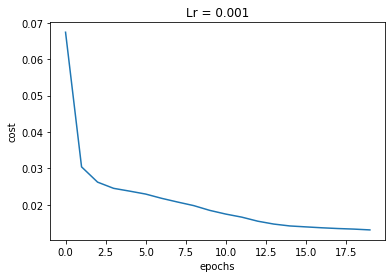

In [ ]:
def model(X, Y, layers, optimizer, epochs = 10, lr = 0.001, mini_batch_size = 128,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, middle_activations='relu',last_activation='softmax'):
    """
    3-layer neural network model which can be run in different optimizer modes.
    
    Arguments:
    X -- input data (number of examples, input_size)
    Y -- input label (number of examples)
    layers -- python list, containing the size of each layer. [input_size,hidden_layer_1,...,hidden_layer_n, output_layer]
    optimizer -- a string, one of ['adam','rmsprop','momentum','gd']
    epochs -- the number of training epoches
    lr -- learning rate, default of 1e-3
    mini_batch_size -- the size of a mini batch defaults to 128
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates 
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    middle_activations -- a string, one of ['relu','sigmoid','linear','softmax'], defaults to relu
    last_activation -- a string, one of ['relu','sigmoid','linear','softmax'], defaults to softmax

    Returns:
    Ws,Bs -- Ws- A list of weights [...(ln,ln+1)...], Bs-a list of biases [...(ln+1,1)...] 
    """

    L = len(layers)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 1                            # initializing the counter required for Adam update
    m = X.shape[0]                   # number of training examples
    
    # Initialize parameters
    
    Ws,Bs = initialize_parameters(layers)
    vdw=[np.zeros(np.shape(i)) for i in Ws]
    vdb=[np.zeros(np.shape(i)) for i in Bs]
    sdw=[np.zeros(np.shape(i)) for i in Ws]
    sdb=[np.zeros(np.shape(i)) for i in Bs]
    minibatches=get_rand_minibatch(X,Y,mini_batch_size)
    
    
    # Optimization loop
    for i in range(epochs):
        cost_total = 0
        
        for minibatch in minibatches:

            # Select a minibatch
            (mini_X, mini_Y) = minibatch

            # Forward propagation
            As,Zs = forward_prop(Ws,Bs,mini_X,middle_activations='relu',last_activation='softmax')
            Yhat=As[-1]

            # Compute cost and add to the cost total
            cost_total += categorical_crossentropy(mini_Y,Yhat)

            # Backward propagation
            dWs,dBs = back_prop(Ws,As,mini_Y,Zs,middle_activations='relu',last_activation='linear')

            # Optimization step
            Ws,Bs=optmize(Ws,Bs,dWs,dBs,vdw,vdb,sdw,sdb,optimizer=optimizer,learn_rate=lr,beta1=beta1,beta2= beta2,eps=epsilon,t=t)
            t+=1
            
        cost = cost_total / m
        if i%2==0:
            print(cost)
        costs.append(cost)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs')
    
    plt.title("Lr = " + str(lr))
    plt.show()

    return Ws,Bs

In [ ]:
Ws,Bs=model(train_X, train_Y_oh, layers=[784,12,11,10], optimizer="adam", epochs = 20, lr = 1e-3, mini_batch_size = 64,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8)

In [ ]:
def predict(X,Ws,Bs):
    """Returns a prediction given
    X -- a single input
    Ws -- a list of weight, [(input_size,layer1),...,(layer n-1,output_size)]
    Bs -- a list of biases, [(input_size,1),...,(output_size,1)]
    """
    As,Zs = forward_prop(Ws,Bs,X)
    Yhat=As[-1]
    prediction=np.argmax(Yhat,axis=-1)
    return prediction

[4]


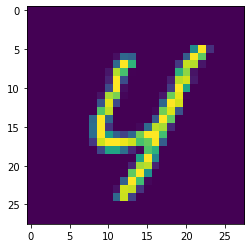

In [ ]:
idx=555
print(predict(test_X[idx,:],Ws,Bs))
plt.imshow(np.reshape(test_X[idx,:],(28,28)))

In [ ]:
predicts=predict(train_X,Ws,Bs)
acc=np.count_nonzero(predicts==train_Y)/len(train_Y)
print(acc)

0.7826833333333333


#Checking the backpropagation gradient

In [ ]:
X_test=train_X[0:2,:]
Y_test=train_Y_oh[0:2]
Ws,bs=initialize_parameters(layers)

In [ ]:

As,Zs=forward_prop(Ws,bs,X_test,middle_activations='sigmoid',last_activation='softmax')
dWs,dBs=back_prop(Ws,As,Y_test,Zs,middle_activations='sigmoid',last_activation='softmax')



eps=1e-6
layer=2
idx=(2,5)
"""Computing partial derivative"""
Wplus=copy.deepcopy(Ws)
Wminus=copy.deepcopy(Ws)
Wplus[layer][idx]=Ws[layer][idx]+eps
Wminus[layer][idx]=Ws[layer][idx]-eps
AsPlus,_=forward_prop(Wplus,bs,X_test,middle_activations='sigmoid',last_activation='softmax')
AsMinus,_=forward_prop(Wminus,bs,X_test,middle_activations='sigmoid',last_activation='softmax')
Jplus=categorical_crossentropy(Y_test,AsPlus[-1])
Jminus=categorical_crossentropy(Y_test,AsMinus[-1])
dWtest=(Jplus-Jminus)/(2*eps)


print(dWtest,dWs[layer][idx])

-0.4552034247318204 -0.4552034243939695
